In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"spideyy1122","key":"c15fc58352d2422295745896a4ec4fcb"}'}

In [3]:
# Create the .kaggle directory
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
!cp kaggle.json ~/.kaggle/

# Set the correct permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:01<00:00, 132MB/s]
100% 149M/149M [00:01<00:00, 100MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip

In [6]:
!ls

brain-tumor-mri-dataset.zip  kaggle.json  sample_data  Testing	Training


In [7]:
# Step 1: Import Libraries
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# TensorFlow/Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Step 2: Load the Dataset

# Define the function to load training data
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])
    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

# Define the function to load testing data
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

# Paths to the dataset
train_path = './Training'  # Path to the Training folder
test_path = './Testing'    # Path to the Testing folder

# Load the training and testing data
tr_df = train_df(train_path)
ts_df = test_df(test_path)

# Display the first few rows of the training and testing DataFrames
print("Training Data:")
print(tr_df.head())

print("\nTesting Data:")
print(ts_df.head())

Training Data:
                            Class Path      Class
0  ./Training/pituitary/Tr-pi_0711.jpg  pituitary
1  ./Training/pituitary/Tr-pi_1214.jpg  pituitary
2  ./Training/pituitary/Tr-pi_1153.jpg  pituitary
3  ./Training/pituitary/Tr-pi_1009.jpg  pituitary
4  ./Training/pituitary/Tr-pi_1202.jpg  pituitary

Testing Data:
                             Class Path      Class
0    ./Testing/pituitary/Te-pi_0187.jpg  pituitary
1  ./Testing/pituitary/Te-piTr_0001.jpg  pituitary
2    ./Testing/pituitary/Te-pi_0043.jpg  pituitary
3    ./Testing/pituitary/Te-pi_0165.jpg  pituitary
4    ./Testing/pituitary/Te-pi_0155.jpg  pituitary


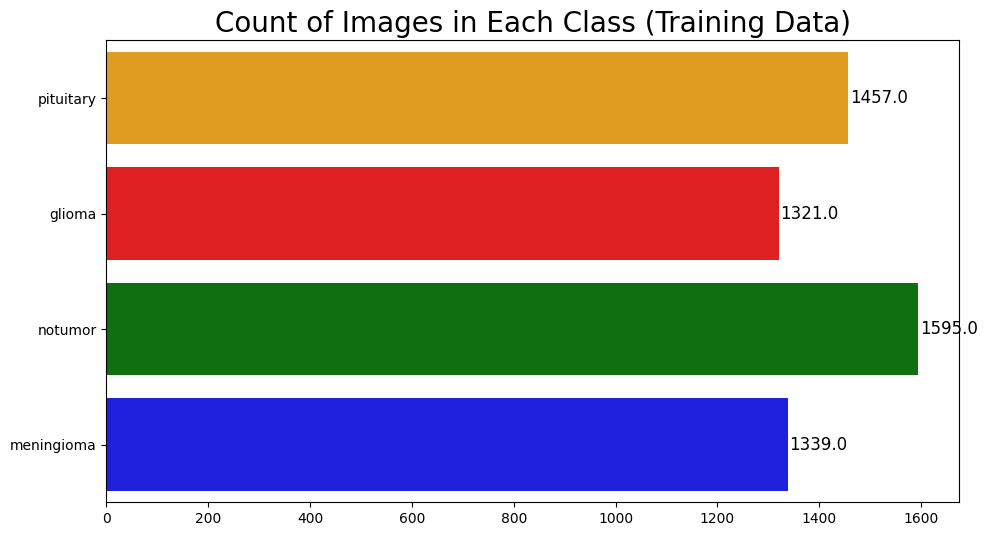

In [15]:
plt.figure(figsize=(11, 6))
custom_palette = {"glioma": "red", "meningioma": "blue", "notumor": "green", "pituitary": "orange"}
ax = sns.countplot(data=tr_df, y=tr_df['Class'], palette=custom_palette)
plt.xlabel('')
plt.ylabel('')
plt.title('Count of Images in Each Class (Training Data)', fontsize=20)

# Manually add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width() + 60, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

plt.show()

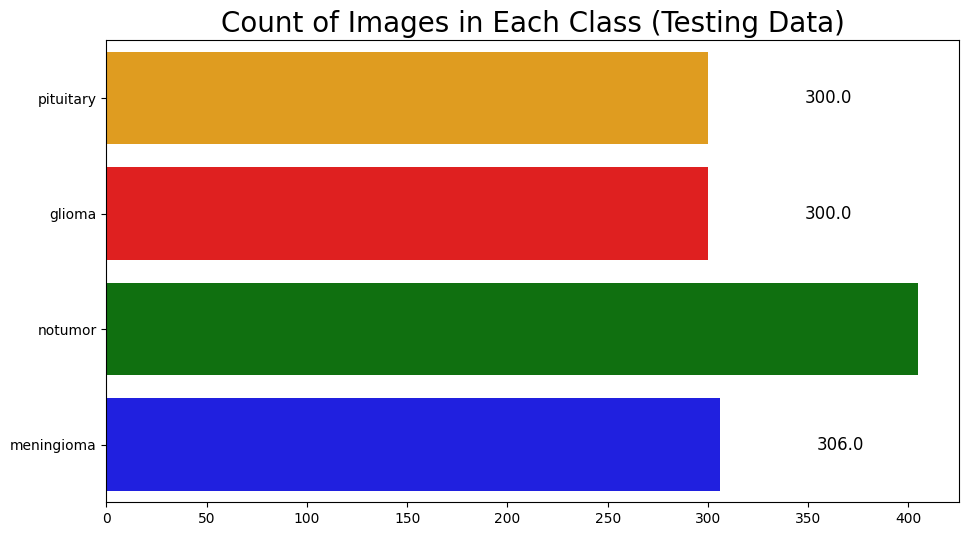

In [21]:
# Plot Testing Data Distribution
plt.figure(figsize=(11, 6))
ax = sns.countplot(data=ts_df, y=ts_df['Class'], palette=custom_palette)
plt.xlabel('')
plt.ylabel('')
plt.title('Count of Images in Each Class (Testing Data)', fontsize=20)

# Manually add counts on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width() + 60, p.get_y() + p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

plt.show()

In [22]:
# Step 4: Split the Data into Validation and Test Sets

# Split the testing data into validation and test sets
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

# Display the first few rows of the validation and test DataFrames
print("Validation Data:")
print(valid_df.head())

print("\nTest Data:")
print(ts_df.head())

Validation Data:
                               Class Path       Class
586       ./Testing/glioma/Te-gl_0035.jpg      glioma
1023  ./Testing/meningioma/Te-me_0246.jpg  meningioma
61     ./Testing/pituitary/Te-pi_0161.jpg   pituitary
1078  ./Testing/meningioma/Te-me_0068.jpg  meningioma
409       ./Testing/glioma/Te-gl_0288.jpg      glioma

Test Data:
                               Class Path       Class
1271  ./Testing/meningioma/Te-me_0295.jpg  meningioma
458       ./Testing/glioma/Te-gl_0041.jpg      glioma
1188  ./Testing/meningioma/Te-me_0276.jpg  meningioma
794      ./Testing/notumor/Te-no_0337.jpg     notumor
910      ./Testing/notumor/Te-no_0327.jpg     notumor


In [ ]:
# Step 5: Data Preprocessing

# Define batch size and image size
batch_size = 32
img_size = (299, 299)

# Create ImageDataGenerators
_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8, 1.2))  # For training and validation data
ts_gen = ImageDataGenerator(rescale=1/255)  # For testing data

# Generate batches of training data
tr_gen = _gen.flow_from_dataframe(
    tr_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

# Generate batches of validation data
valid_gen = _gen.flow_from_dataframe(
    valid_df,
    x_col='Class Path',
    y_col='Class',
    batch_size=batch_size,
    target_size=img_size
)

# Generate batches of testing data
ts_gen = ts_gen.flow_from_dataframe(
    ts_df,  
    x_col='Class Path',
    y_col='Class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


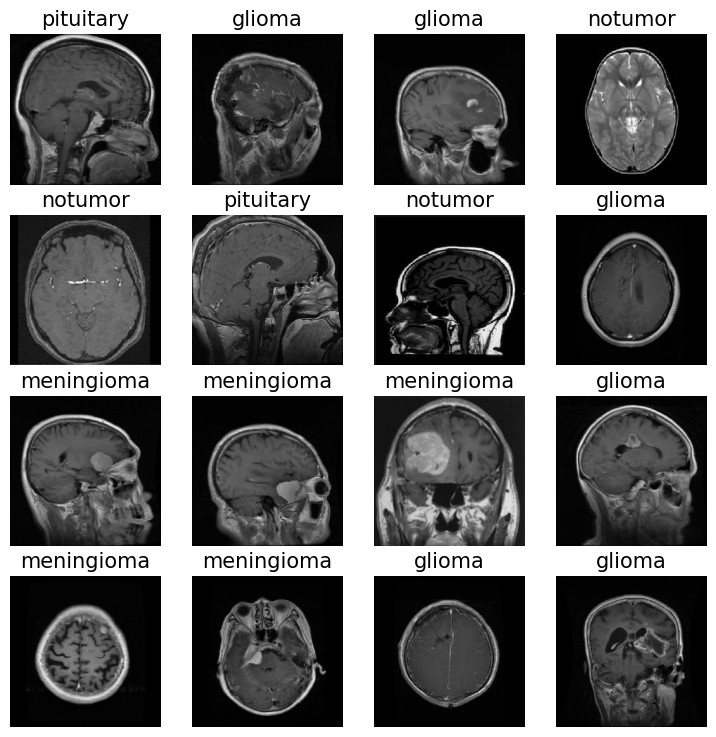

In [26]:
# Step 6: Visualize Samples from the Test Data

# Get the class indices and class names
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())

# Get the next batch of images and labels from the test generator
images, labels = next(ts_gen)

# Plot the images with their corresponding class names
plt.figure(figsize=(9, 9))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]  # Get the class name from the one-hot encoded label
    plt.title(class_name, color='k', fontsize=15)
    plt.axis('off')  # Turn off axis for better visualization

plt.show()

In [27]:
# Step 7: Build the Deep Learning Model

# Define the input shape
img_shape = (299, 299, 3)

# Load the Xception model with pre-trained weights
base_model = tf.keras.applications.Xception(
    include_top=False,       # Exclude the top classification layer
    weights="imagenet",      # Use pre-trained weights from ImageNet
    input_shape=img_shape,   # Input shape for the model
    pooling='max'            # Global max pooling at the end of the base model
)

# Freeze the base model layers (optional)
# Uncomment the following lines if you want to freeze the base model
# for layer in base_model.layers:
#     layer.trainable = False

# Build the sequential model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),               # Dropout layer to reduce overfitting
    Dense(128, activation='relu'),    # Fully connected layer with 128 units
    Dropout(rate=0.25),               # Another dropout layer
    Dense(4, activation='softmax')    # Output layer with 4 units (one for each class)
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),  # Optimizer
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy', Precision(), Recall()]  # Metrics to monitor during training
)

# Display the model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

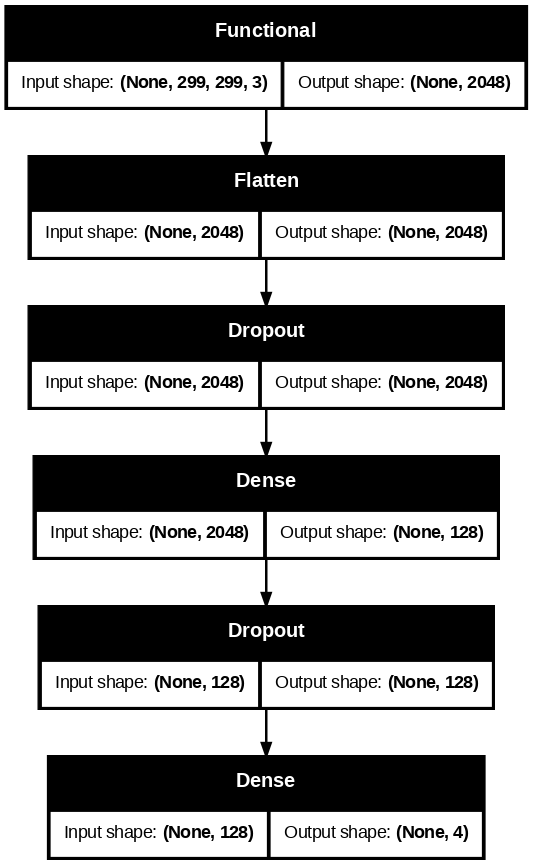

In [30]:
# Plot the model architecture with a smaller size
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    dpi=90  # Lower DPI for a smaller image
)

In [31]:
hist = model.fit(
    tr_gen,                      # Training data generator
    epochs=10,                   # Number of epochs
    validation_data=valid_gen,   # Validation data generator
    shuffle=False                # Do not shuffle data during training
)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 251s 1s/step - accuracy: 0.7460 - loss: 0.7148 - precision: 0.8337 - recall: 0.6397 - val_accuracy: 0.8840 - val_loss: 0.3148 - val_precision: 0.8840 - val_recall: 0.8840
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 834ms/step - accuracy: 0.9780 - loss: 0.0629 - precision: 0.9837 - recall: 0.9741 - val_accuracy: 0.9802 - val_loss: 0.0681 - val_precision: 0.9801 - val_recall: 0.9756
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 150s 835ms/step - accuracy: 0.9909 - loss: 0.0234 - precision: 0.9922 - recall: 0.9899 - val_accuracy: 0.9832 - val_loss: 0.0525 - val_precision: 0.9832 - val_recall: 0.9832
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 835ms/step - accuracy: 0.9923 - loss: 0.0243 - precision: 0.9929 - recall: 0.9922 - val_accuracy: 0.9954 - val_loss: 0.0121 - val_precision: 0.9954 - val_recall: 0.9954
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 149s 834ms/step - accuracy: 0.9965 - loss: 0.0148 - precision: 0.9966 - recall: 0.9964 - val_accuracy: 0.98

In [32]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

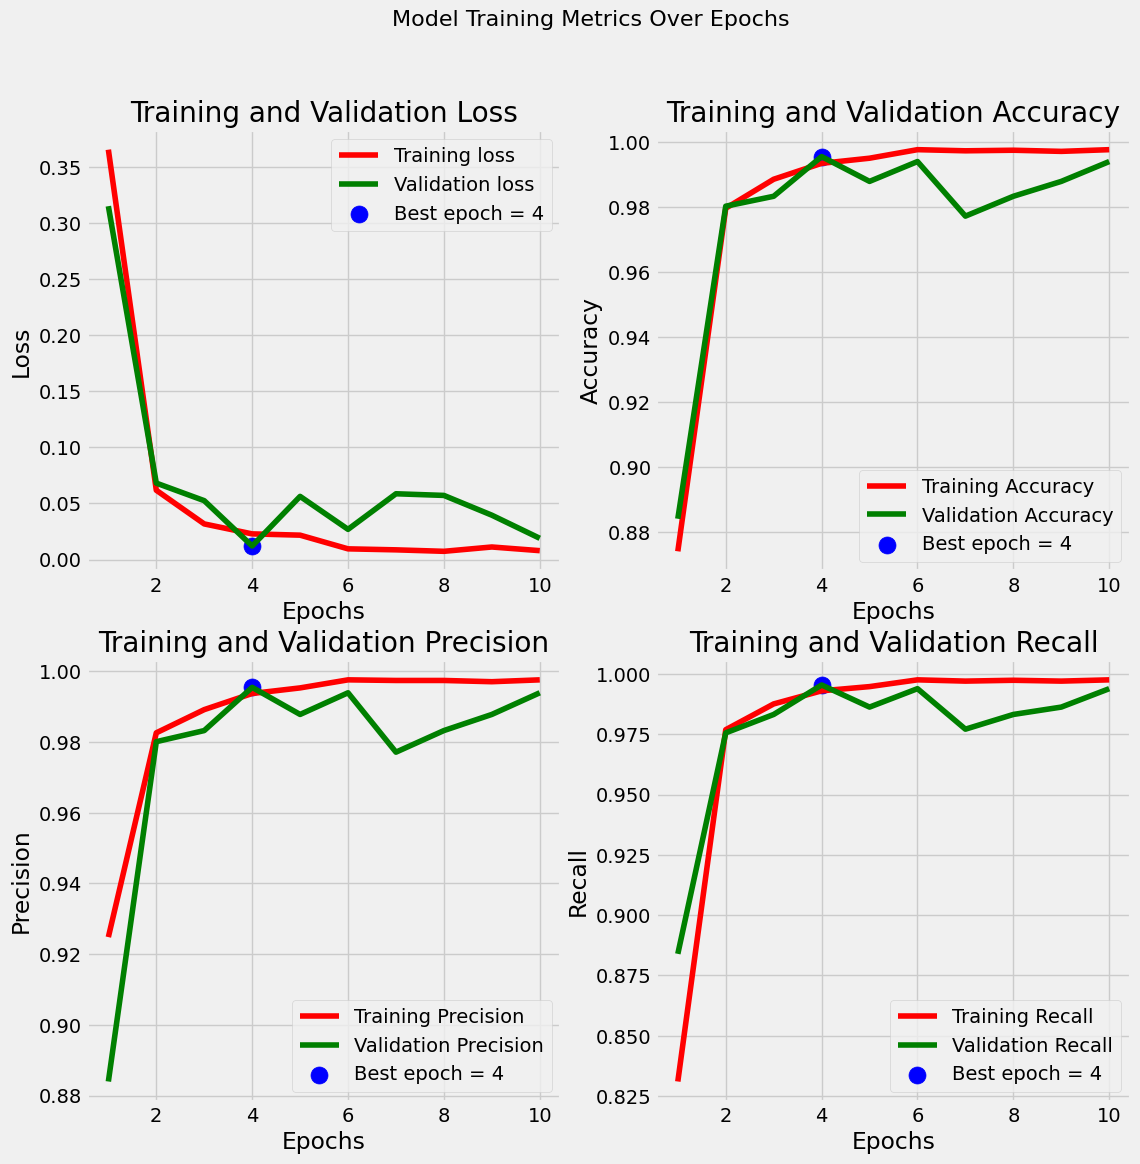

In [34]:
# Step 9: Visualize Model Performance

# Extract metrics from the training history
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']

val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

# Find the best epoch for each metric
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]

index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

# Create a list of epochs for plotting
Epochs = [i + 1 for i in range(len(tr_acc))]

# Labels for the best epochs
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

# Plot the metrics
plt.figure(figsize=(12, 12))
plt.style.use('fivethirtyeight')

# Subplot 1: Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Training and Validation Accuracy
plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Subplot 3: Training and Validation Precision
plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Training Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Subplot 4: Training and Validation Recall
plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Training Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# Add a title for the entire figure
plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [35]:
train_score = model.evaluate(tr_gen, verbose=1)

# Evaluate the model on the validation data
valid_score = model.evaluate(valid_gen, verbose=1)

# Evaluate the model on the test data
test_score = model.evaluate(ts_gen, verbose=1)

# Print the evaluation results
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1] * 100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1] * 100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 41s 230ms/step - accuracy: 0.9983 - loss: 0.0049 - precision: 0.9984 - recall: 0.9983
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9931 - loss: 0.0223 - precision: 0.9931 - recall: 0.9931
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.9898 - loss: 0.0479 - precision: 0.9898 - recall: 0.9898
Train Loss: 0.0033
Train Accuracy: 99.88%
--------------------
Validation Loss: 0.0185
Validation Accuracy: 99.39%
--------------------
Test Loss: 0.0525
Test Accuracy: 98.63%


In [36]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step


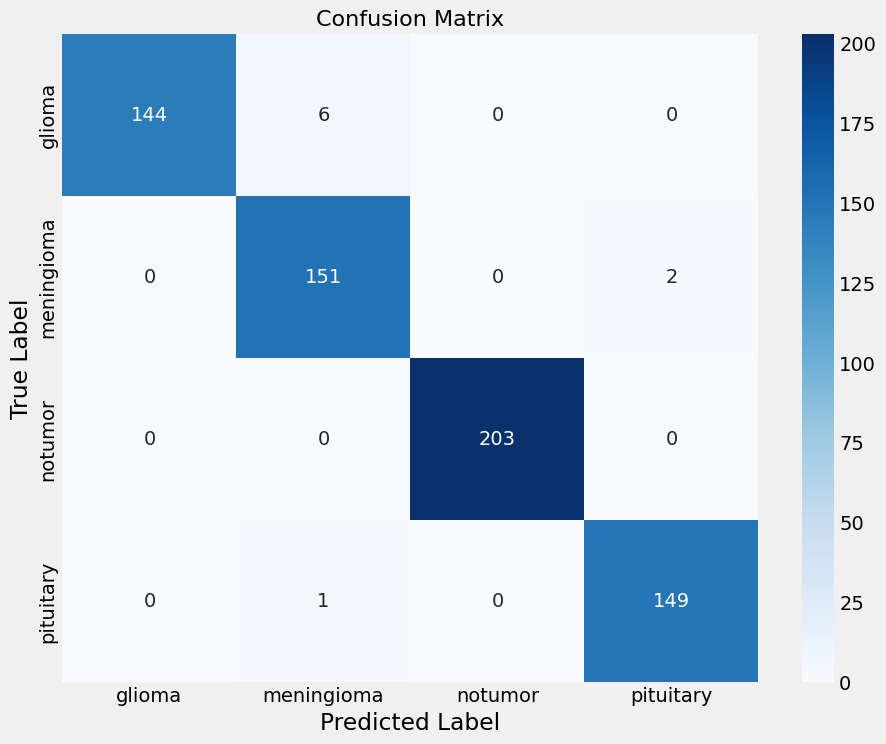

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.96      0.98       150
  meningioma       0.96      0.99      0.97       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      0.99      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656



In [37]:

# Generate the confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred)

# Plot the confusion matrix
labels = list(class_dict.keys())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', fontsize=16)
plt.show()

# Generate the classification report
clr = classification_report(ts_gen.classes, y_pred, target_names=labels)
print("Classification Report:")
print(clr)

In [ ]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score

roc_auc = roc_auc_score(ts_gen.classes, preds, multi_class='ovr')

kappa = cohen_kappa_score(ts_gen.classes, y_pred)

print(f"ROC-AUC Score: {roc_auc:.4f}")

print(f"Cohen's Kappa Score: {kappa:.4f}")


ROC-AUC Score: 0.9997
Cohen's Kappa Score: 0.9816


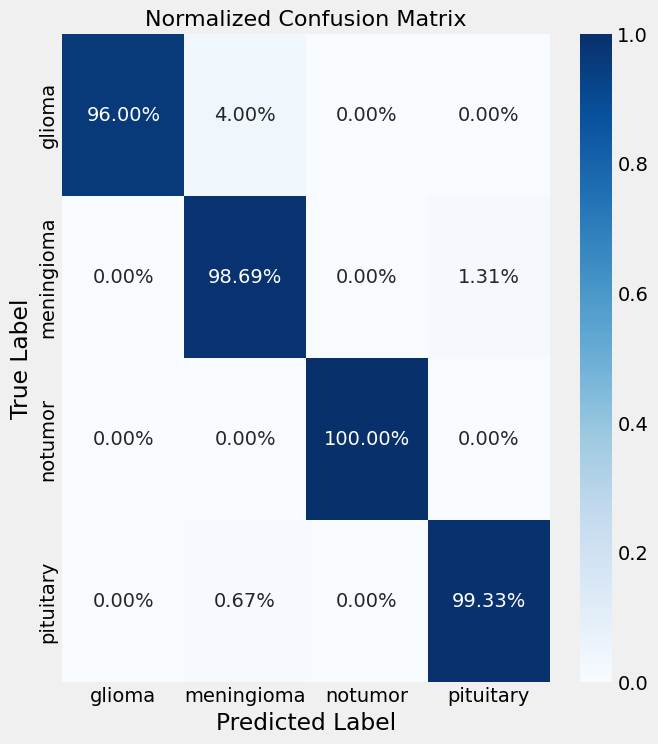

In [53]:
# Plot Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

plt.figure(figsize=(7,8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix', fontsize=16)
plt.show()

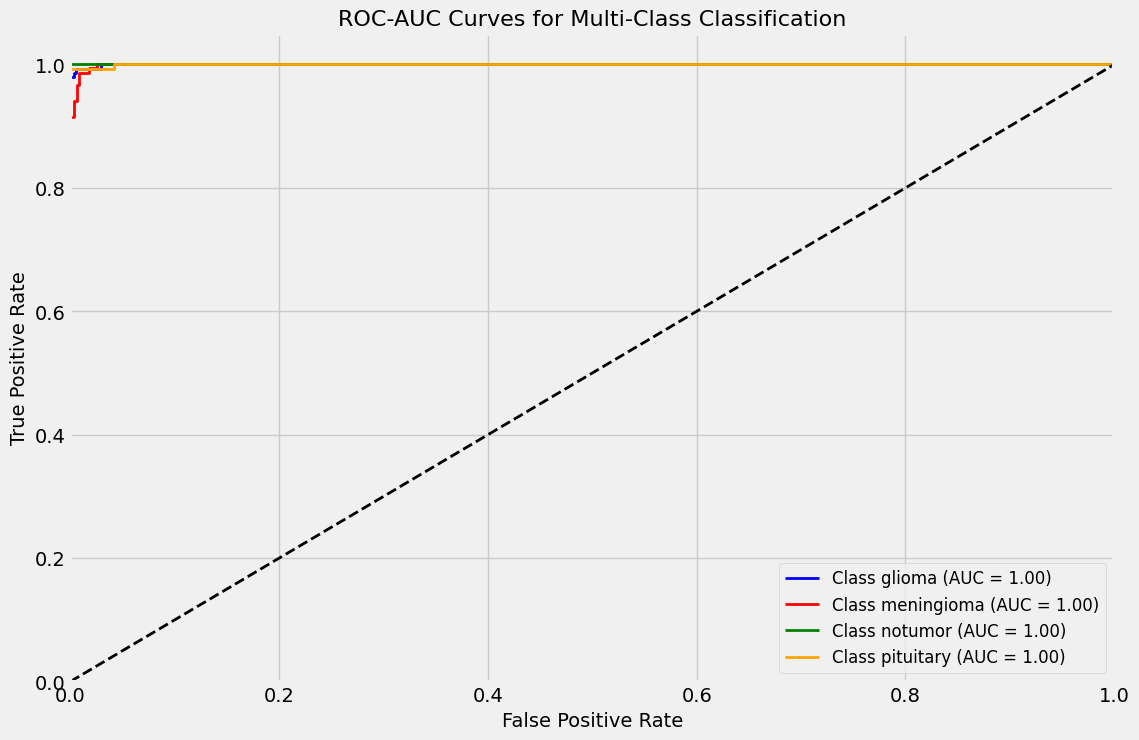

In [59]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Binarize the true labels
y_true_bin = label_binarize(ts_gen.classes, classes=[0, 1, 2, 3])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC-AUC Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

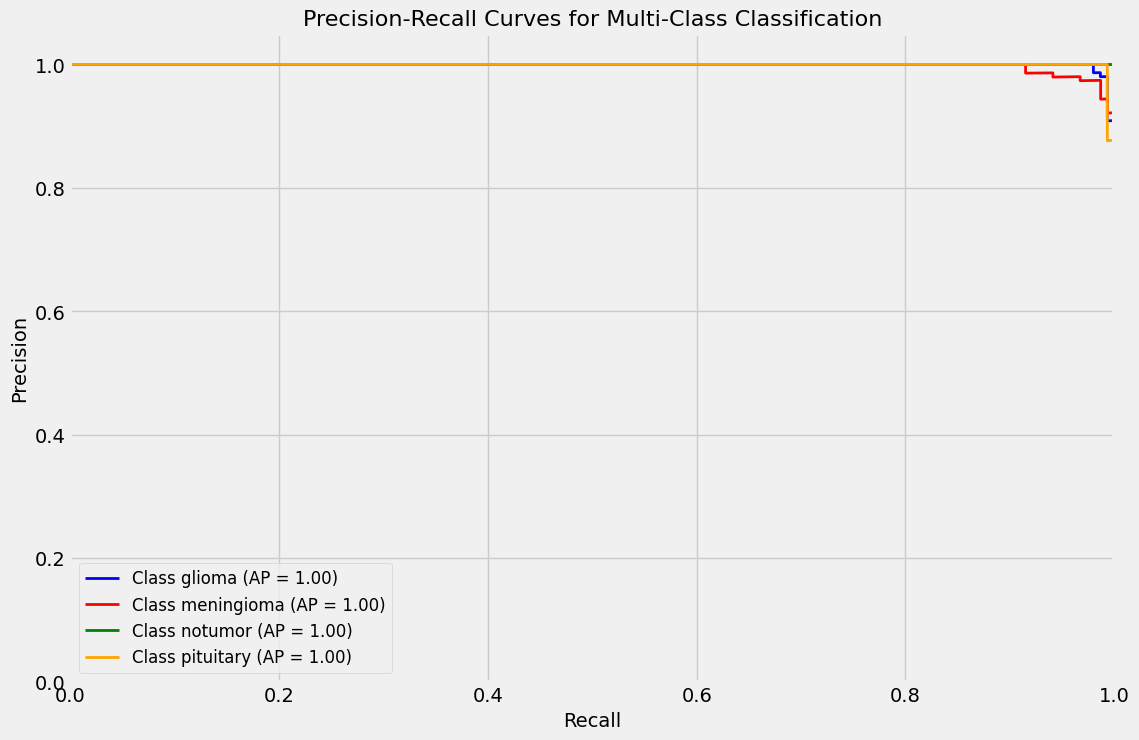

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], preds[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], preds[:, i])

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {labels[i]} (AP = {average_precision[i]:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.show()

In [38]:
# Save the model in HDF5 format
model.save('brain_tumor_xception.h5')

In [39]:
from google.colab import files
files.download('brain_tumor_xception.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
# Step 1: Load the Saved Model
from tensorflow.keras.models import load_model

# Load the model from the saved file
model = load_model('brain_tumor_xception.h5')

# Verify the model architecture (optional)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,270 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

 Optimizer params: 2 (12.00 B)

In [66]:
# Step 2: Define the Prediction Function
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # Get the class labels
    label = list(class_dict.keys())

    # Load and preprocess the image
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))  # Resize to match the input size of the model
    img_array = np.asarray(resized_img)   # Convert to NumPy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0                  # Normalize pixel values to [0, 1]

    # Make predictions
    predictions = model.predict(img_array)
    probs = list(predictions[0])  # Extract probabilities for each class

    # Plot the image and probabilities
    plt.figure(figsize=(6,5))
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.axis('off')  # Turn off axis for better visualization

    plt.subplot(2, 1, 2)
    bars = plt.barh(label, probs, color='blue')  # Horizontal bar chart for probabilities
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt='%.2f')  # Add probability values on top of bars
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


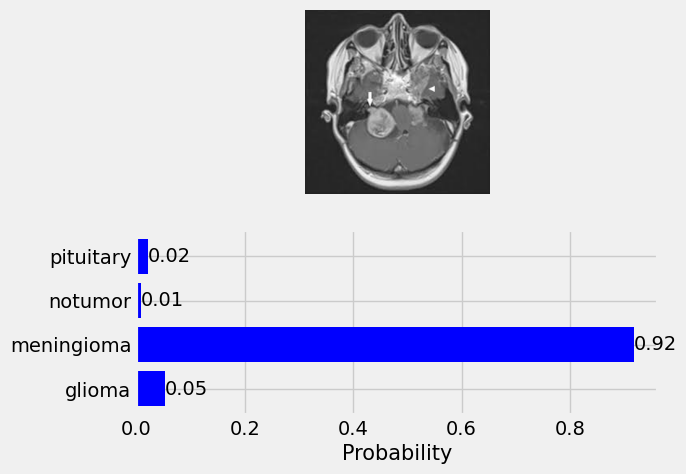

In [67]:

predict('/content/Testing/meningioma/Te-meTr_0002.jpg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


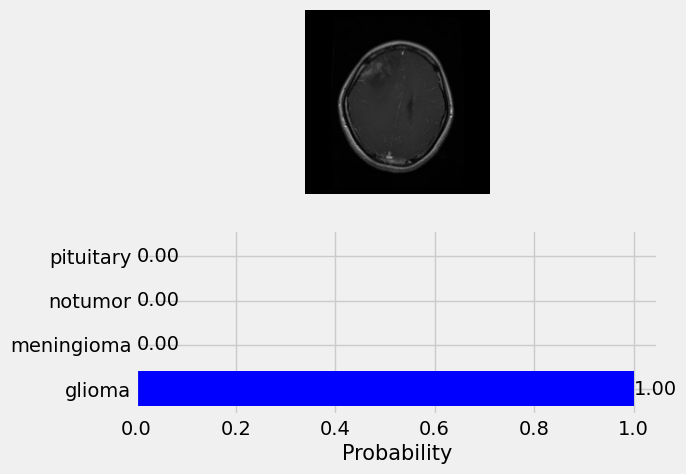

In [68]:
predict('/content/Testing/glioma/Te-glTr_0002.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


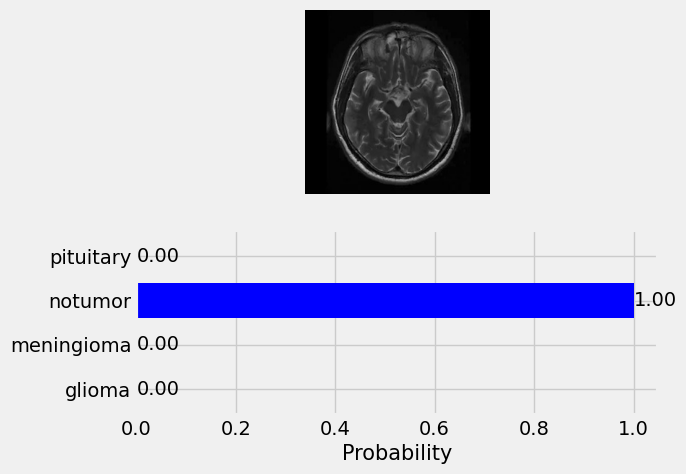

In [69]:
predict('/content/Testing/notumor/Te-noTr_0006.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


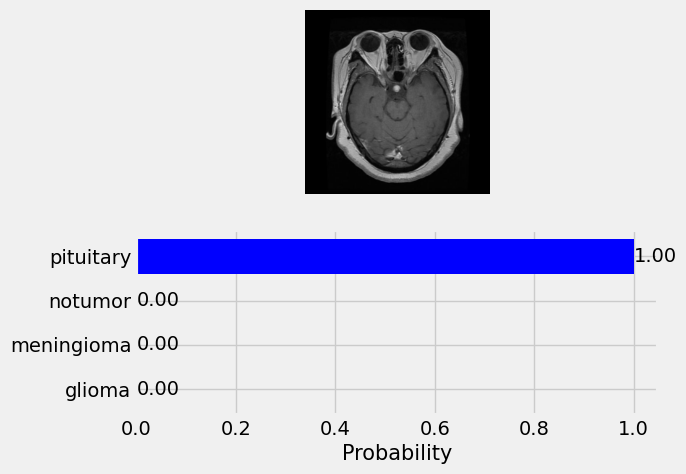

In [70]:
predict('/content/Testing/pituitary/Te-pi_0010.jpg')